# Detection and Tracking in Ultimate Frisbee

In [1]:
import os
import cv2
import numpy as np
from numpy.linalg import svd, inv
%matplotlib inline
from matplotlib import pyplot as plt
from math import floor
import utils
import scipy.ndimage as ndi

In [2]:
# INITIALIZE VARIABLES

# SET UP CLIP NUMER AND RESOLUTION
clip_num = 5
res_w = 640
res_h = 360
org_h = 360

# SET UP CANVAS FOR PROJECTING FRAMES ON
proj_w = 1000
proj_h = 500
off_x = 200
off_y = 70

# SET UP LOWER AND UPPER RANGE FOR LINE DETECTION
hsv_lower = np.array([50,40,128])
hsv_upper = np.array([65,255,255])

# SET UP LOWER AND UPPER RANGE FOR PLAYER DETECTION
lower = np.array([0,32,0])
upper = np.array([179,255,255])

# SET THRESHOLDS FOR AREA/RATIO FOR PLAYER TRACKING
a_bd = 19
aw_bd = 3
ah_lbd = 1
ah_ubd = 8
ar_bd = 0.2
r_bd = 0.5

# SET UP SINGLE FRAME TO TEST
test_frame = 190

# SET UP MINIMAP SIZE ON FRAME
map_w = int(res_w/5)
map_h = int(res_h/5)

### Set up data

In [3]:
# CONVERTING VIDEO CLIPS INTO FRAMES
# input_file = 'data/input/clip-{}.mp4'.format(clip_num)
# output_path = 'images/input/clip-{}/'.format(clip_num)
# utils.video2imageFolder(input_file, output_path)

In [4]:
# STORE IMAGE FRAMES INTO ARRAY
dir_frames = 'images/input/clip-{}'.format(clip_num)
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels), dtype=np.uint8)

for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.imread(file_i)

In [5]:
# COMPRESS RESOLUTION OF EACH FRAME
# for i in range(len(frames)):
#     projectedSource = cv2.resize(frames[i], (res_w,org_h))
#     # for cropping scoreboard out..
#     projectedSource = projectedSource[:res_h,:]
#     cv2.imwrite('images/input/clip-{}/f{:04d}.jpg'.format(clip_num, i+1), projectedSource)

### Get homographies, background, and foreground by applying video stitching from project 5

#### Part A: Stitch two key frames

In [6]:
def auto_homography(Ia, Ib, homography_func=None, normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)
    mask = np.ones(Ia.shape, dtype=np.uint8)
    for y in range(10,50):
        for x in range(30,250):
            mask[y][x][:] = 0
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 2500
    best_score = 0
    best_pts1 = np.zeros((3, 4))
    best_pts2 = np.zeros((3, 4))

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, 4, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (compute_homography)

        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        du = Xb_[0,:]/Xb_[2,:] - Xb[0,:]/Xb[2,:]
        dv = Xb_[1,:]/Xb_[2,:] - Xb[1,:]/Xb[2,:]

        ok_t = np.sqrt(du**2 + dv**2) < 1.5  # you may need to play with this threshold
        score_t = sum(ok_t)

        if score_t > best_score:
            best_score = score_t
            best_pts1 = pts1
            best_pts2 = pts2
            H = H_t
            in_idx = ok_t
            
    # print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [7]:
def compute_homography(pts1, pts2, normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    n = 4
    e = 0
    A = np.zeros((2*n, 9))
    
    # iterate through all points to get A matrix used to solve for H
    for i in range(n):
        # set u, v, u', v'
        u = pts1[0][i]
        v = pts1[1][i]
        ut = pts2[0][i]
        vt = pts2[1][i]
        
        # set each row to the two equations obtained from each point
        A[e] = np.array([ -u, -v, -1, 0, 0, 0, u*ut, v*ut, ut ])
        A[e+1] = np.array([ 0, 0, 0, -u, -v, -1, u*vt, v*vt, vt ])
        e = e + 2
    
    # solve the least squares to get H
    u,s,vh = np.linalg.svd(A)
    h = vh.T[:, -1]
    H = h.reshape(3,3)
    
    return H

In [8]:
f = len(frames)
invl = int(f/10)

In [9]:
key_frames = [invl, 3*invl, 5*invl, 7*invl, 9*invl]

In [10]:
# images location
im1 = './images/input/clip-{}/f{:04d}.jpg'.format(clip_num, key_frames[1])
im2 = './images/input/clip-{}/f{:04d}.jpg'.format(clip_num, key_frames[2])
im3 = './images/input/clip-{}/f{:04d}.jpg'.format(clip_num, key_frames[3])
im4 = './images/input/clip-{}/f{:04d}.jpg'.format(clip_num, key_frames[0])
im5 = './images/input/clip-{}/f{:04d}.jpg'.format(clip_num, key_frames[4])

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)
im3 = cv2.imread(im3)
im4 = cv2.imread(im4)
im5 = cv2.imread(im5)

In [11]:
H = auto_homography(im1, im2, compute_homography)
im1_outline = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2_outline = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

In [12]:
# set rectangle coordinates
rect = np.array([[300,300,400,400],[50,100,100,50],[1,1,1,1]])
rect_T = np.dot(H, rect)
rect_T = rect_T / rect_T[2]
rect = rect.T[:,0:2]
rect_T = rect_T.T[:,0:2]

# draw rectangle on first image
im1_outline = im1.copy()
im1_outline = cv2.polylines(im1_outline, [rect], isClosed=True, color=(0,0,215), thickness=2)
im1_outline = cv2.cvtColor(im1_outline, cv2.COLOR_BGR2RGB)

# draw projected rectangle on second image
im2_outline = im2.copy()
im2_outline = cv2.polylines(im2_outline, [np.int32(rect_T)], isClosed=True, color=(0,0,215), thickness=2)
im2_outline = cv2.cvtColor(im2_outline, cv2.COLOR_BGR2RGB)

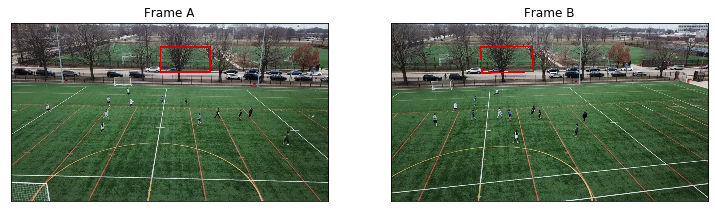

In [13]:
outlines = np.stack((im1_outline, im2_outline))
titles = ['Frame A', 'Frame B']

fig, axes = plt.subplots(1,2, figsize=(12.5,5))
for i in range(2):
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].set_title(titles[i])
    axes[i].imshow(outlines[i])

In [14]:
projectedWidth = proj_w
projectedHeight = proj_h

tx = off_x
ty = off_y
T = np.float32([[1,0,tx],[0,1,ty]])

(-0.5, 999.5, 499.5, -0.5)

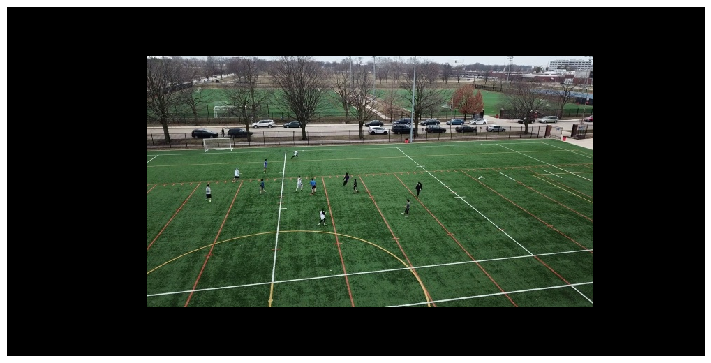

In [15]:
plt.figure(figsize=(12.5,40))
im2_T = cv2.warpAffine(im2, T, (projectedWidth, projectedHeight))
im2_T = cv2.cvtColor(im2_T, cv2.COLOR_BGR2RGB)
plt.imshow(im2_T)
plt.axis('off')

In [16]:
H_1 = auto_homography(im1, im2_T, compute_homography)
I = np.identity(3)

projectedSource = cv2.warpPerspective(im1, H_1, (projectedWidth, projectedHeight))
projectedReference = cv2.warpPerspective(im2_T, I, (projectedWidth, projectedHeight))

(-0.5, 999.5, 499.5, -0.5)

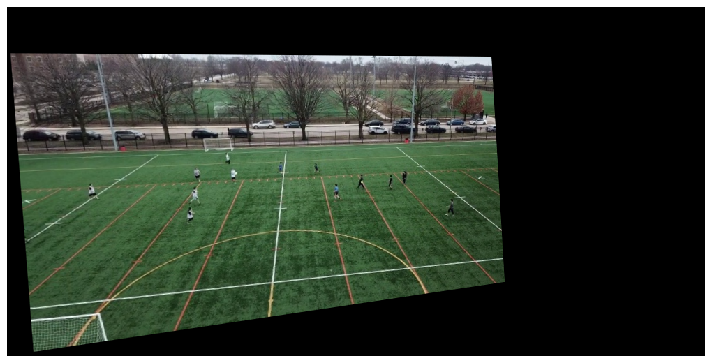

In [17]:
plt.figure(figsize=(12.5,40))
projectedSource = cv2.cvtColor(projectedSource, cv2.COLOR_BGR2RGB)
plt.imshow(projectedSource)
plt.axis('off')

(-0.5, 999.5, 499.5, -0.5)

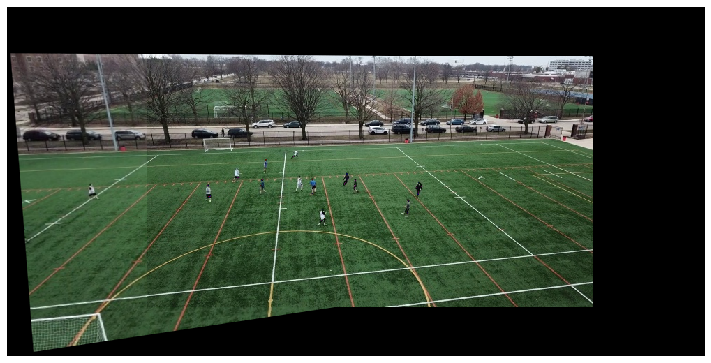

In [18]:
## Example usage of utils.blendImages
blendedOutput = utils.blendImages(projectedSource, projectedReference)
plt.figure(figsize=(12.5,40))
plt.imshow(blendedOutput)
plt.axis('off')

#### Part B: Panorama using five key frames

In [19]:
H_1 = auto_homography(im1, im2_T, compute_homography)
projectedSource1 = cv2.warpPerspective(im1, H_1, (projectedWidth, projectedHeight))
projectedSource1 = cv2.cvtColor(projectedSource1, cv2.COLOR_BGR2RGB)

(-0.5, 999.5, 499.5, -0.5)

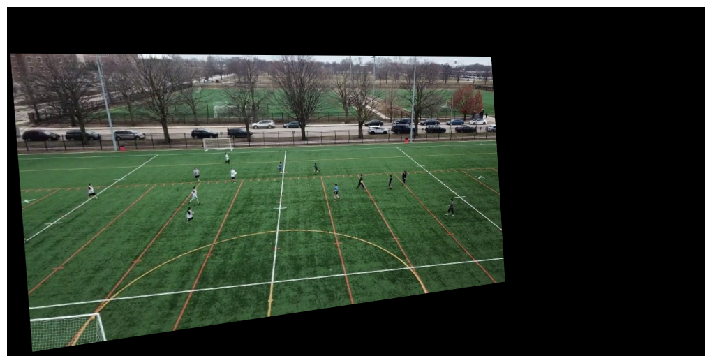

In [20]:
plt.figure(figsize=(12.5,40))
plt.imshow(projectedSource1)
plt.axis('off')

In [21]:
H_2 = auto_homography(im3, im2_T, compute_homography)
projectedSource2 = cv2.warpPerspective(im3, H_2, (projectedWidth, projectedHeight))
projectedSource2 = cv2.cvtColor(projectedSource2, cv2.COLOR_BGR2RGB)

(-0.5, 999.5, 499.5, -0.5)

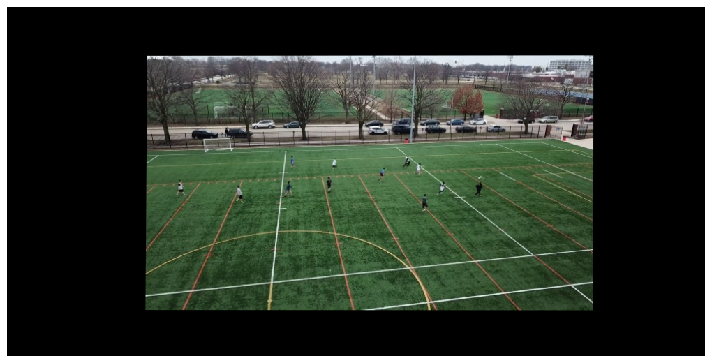

In [22]:
plt.figure(figsize=(12.5,40))
plt.imshow(projectedSource2)
plt.axis('off')

In [23]:
H_3 = auto_homography(im4, projectedSource1, compute_homography)
projectedSource3 = cv2.warpPerspective(im4, H_3, (projectedWidth, projectedHeight))
projectedSource3 = cv2.cvtColor(projectedSource3, cv2.COLOR_BGR2RGB)

(-0.5, 999.5, 499.5, -0.5)

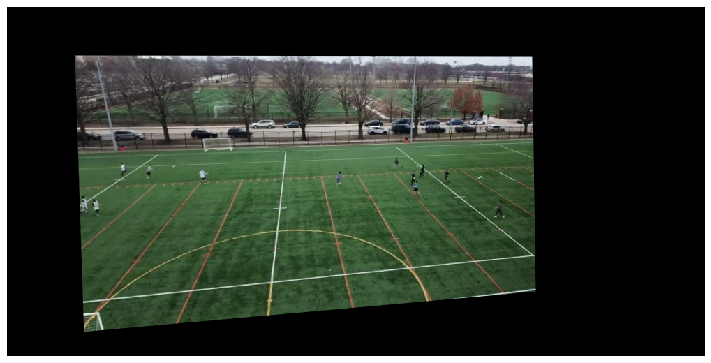

In [24]:
plt.figure(figsize=(12.5,40))
plt.imshow(projectedSource3)
plt.axis('off')

In [25]:
H_4 = auto_homography(im5, projectedSource2, compute_homography)
projectedSource4 = cv2.warpPerspective(im5, H_4, (projectedWidth, projectedHeight))
projectedSource4 = cv2.cvtColor(projectedSource4, cv2.COLOR_BGR2RGB)

(-0.5, 999.5, 499.5, -0.5)

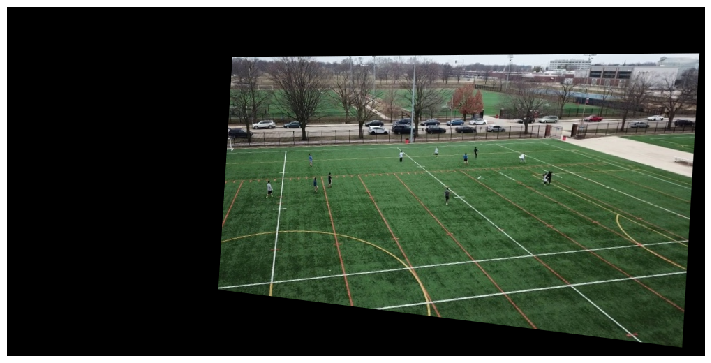

In [26]:
plt.figure(figsize=(12.5,40))
plt.imshow(projectedSource4)
plt.axis('off')

In [27]:
# blends all frames together
blendedOutput_2 = utils.blendImages(projectedSource1, projectedReference)
blendedOutput_2 = utils.blendImages(projectedSource2, blendedOutput_2)
blendedOutput_2 = utils.blendImages(projectedSource3, blendedOutput_2)
blendedOutput_2 = utils.blendImages(projectedSource4, blendedOutput_2)

(-0.5, 999.5, 499.5, -0.5)

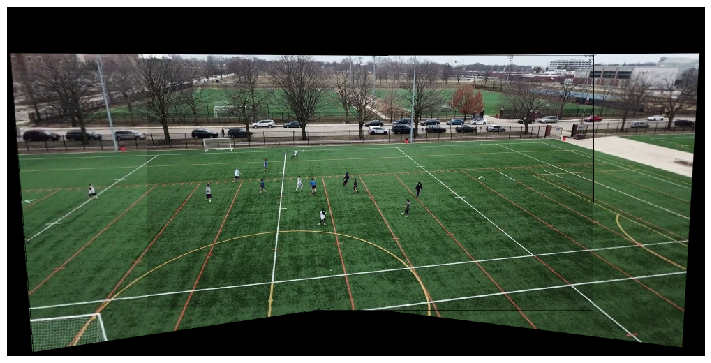

In [28]:
# plot blended panorama of 5 key frames
plt.figure(figsize=(12.5,40))
plt.imshow(blendedOutput_2)
plt.axis('off')

#### Part C: Map the video to the reference plane

In [29]:
# STORE IMAGE FRAMES INTO ARRAY
dir_frames = 'images/input/clip-{}'.format(clip_num)
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels), dtype=np.uint8)

for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.imread(file_i)

In [30]:
key_images = np.array([projectedSource3, projectedSource1, im2_T, projectedSource2, projectedSource4])
homographies = np.zeros((f, 3, 3))

In [31]:
# read from homography file
homographies = np.loadtxt('homography/clip-{}.txt'.format(clip_num))
homographies = homographies.reshape((f, 3, 3))

In [32]:
images = np.zeros((f, projectedHeight, projectedWidth, 3))

In [33]:
blend = blendedOutput_2.copy()

In [34]:
half = int(f/2)-1
for i in range(f):
    if i == half:
        im_mid = cv2.warpAffine(im2, T, (projectedWidth, projectedHeight))
        projectedSource = cv2.warpPerspective(im_mid, I, (projectedWidth, projectedHeight))
    else:
        # H_i = auto_homography(frames[i], key_images[i//80], compute_homography)
        # omographies[i] = H_i
        projectedSource = cv2.warpPerspective(frames[i], homographies[i], (projectedWidth, projectedHeight))
    images[i] = cv2.cvtColor(projectedSource, cv2.COLOR_BGR2RGB)
    blend = utils.blendImages(images[i], blend)
    # cv2.imwrite('images/output/clip-{}/aligned/a{:04d}.jpg'.format(clip_num, i+1), projectedSource)
# utils.imageFolder2mpeg('images/output/clip-{}/aligned'.format(clip_num), fps=30)

(-0.5, 999.5, 499.5, -0.5)

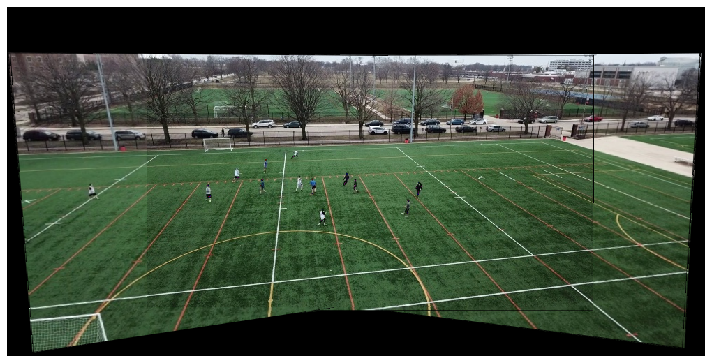

In [35]:
# plot panorama
plt.figure(figsize=(12.5,40))
plt.imshow(blend)
plt.axis('off')

#### Part D: Create background panorama

In [36]:
sum_image = np.sum(images, axis=3, dtype=np.uint8)
sum_image[sum_image > 0] = 1
mask = np.sum(sum_image, axis=0)
sum_of_frames = np.sum(images, axis=0)
mask[mask == 0] = 1

In [37]:
# read from mean file
mean_frames = np.loadtxt('mean/clip-{}.txt'.format(clip_num))
mean_frames = mean_frames.reshape((projectedHeight, projectedWidth, 3))
mean_frames = mean_frames.astype(np.uint8)

(-0.5, 999.5, 499.5, -0.5)

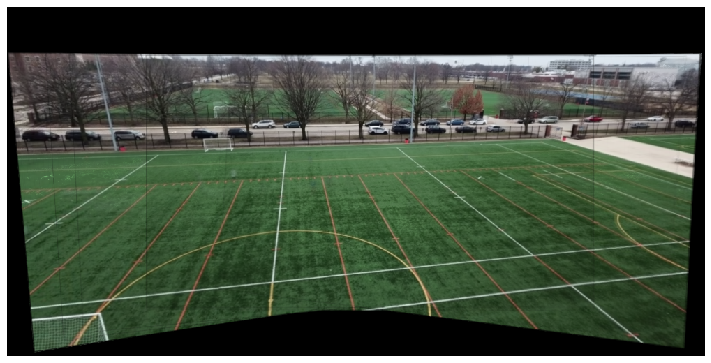

In [38]:
# plot background panorama using mean
plt.figure(figsize=(12.5,40))
plt.imshow(mean_frames)
plt.axis('off')

In [39]:
# read from median file
median_frames = np.loadtxt('median/clip-{}.txt'.format(clip_num))
median_frames = median_frames.reshape((projectedHeight, projectedWidth, 3))
median_frames = median_frames.astype(np.uint8)

(-0.5, 999.5, 499.5, -0.5)

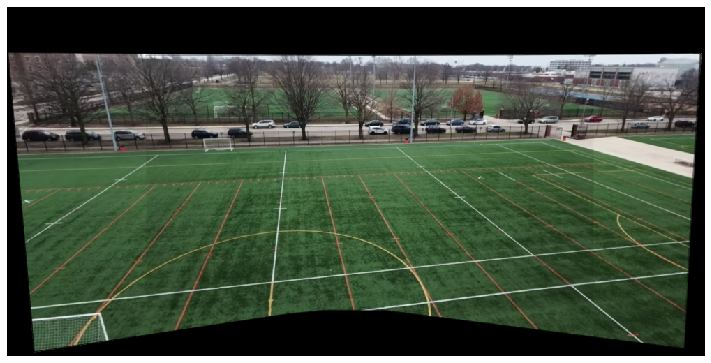

In [40]:
# plot background panorama using mean
plt.figure(figsize=(12.5,40))
plt.imshow(median_frames)
plt.axis('off')

#### Part E: Create background movie

In [41]:
tx = -1*off_x
ty = -1*off_y
T = np.float32([[1,0,tx],[0,1,ty]])

In [42]:
bg_panorama = median_frames.copy()
bg_images = np.zeros((f, projectedHeight, projectedWidth, 3), dtype=np.uint8)
bg_frames = np.zeros((f,res_h,res_w,3), dtype=np.uint8)
for i in range(f):
    for c in range(3):
        bg_images[i,:,:,c] = bg_panorama[:,:,c]

In [43]:
half = int(f/2)-1
for n in range(f):
    if n == half:
        frame_i = cv2.warpPerspective(bg_images[n], I, (projectedWidth, projectedHeight))
        frame_i = cv2.warpAffine(frame_i, T, (projectedWidth, projectedHeight))
    else:
        Hi_i = inv(np.matrix(homographies[n]))
        frame_i = cv2.warpPerspective(bg_images[n], Hi_i, (projectedWidth, projectedHeight))
    frame_i = cv2.cvtColor(frame_i, cv2.COLOR_RGB2BGR)
    bg_frames[n] = frame_i[0:res_h,0:res_w]
    # cv2.imwrite('images/output/clip-{}/background/b{:04d}.jpg'.format(clip_num, n+1), bg_frames[n])
# utils.imageFolder2mpeg('images/output/clip-{}/background'.format(clip_num), fps=30)

#### Part F: Create foreground movie

In [44]:
fg_frames = np.zeros((f,res_h,res_w,3), dtype=np.uint8)
fg_frames = frames - bg_frames + 128

In [45]:
# for n in range(f):
#     cv2.imwrite('images/output/clip-{}/foreground/f{:04d}.jpg'.format(clip_num,n+1), fg_frames[n])
# utils.imageFolder2mpeg('images/output/clip-{}/foreground'.format(clip_num), fps=30)

### Detecting lines in background image

(-0.5, 999.5, 499.5, -0.5)

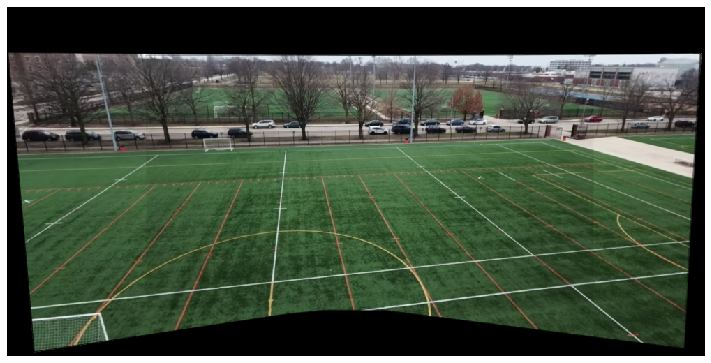

In [46]:
# BACKGROUND IMAGE
field = median_frames.copy()
plt.figure(figsize=(12.5,40))
plt.imshow(field)
plt.axis('off')

(-0.5, 999.5, 499.5, -0.5)

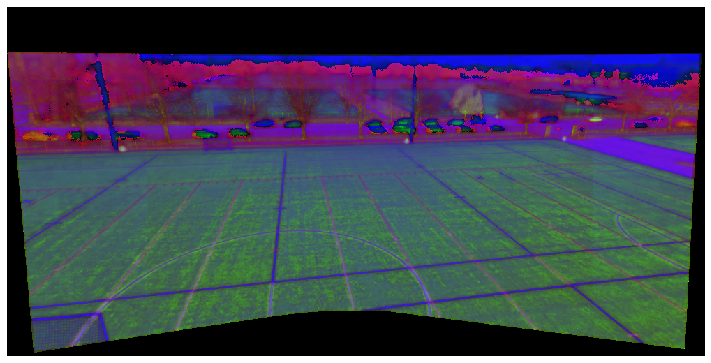

In [47]:
# CONVERT BACKGROUND IMAGE TO HSV
field_lines = field.copy()
hsv_plane = cv2.cvtColor(field, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(12.5,40))
plt.imshow(hsv_plane)
plt.axis('off')

(-0.5, 999.5, 499.5, -0.5)

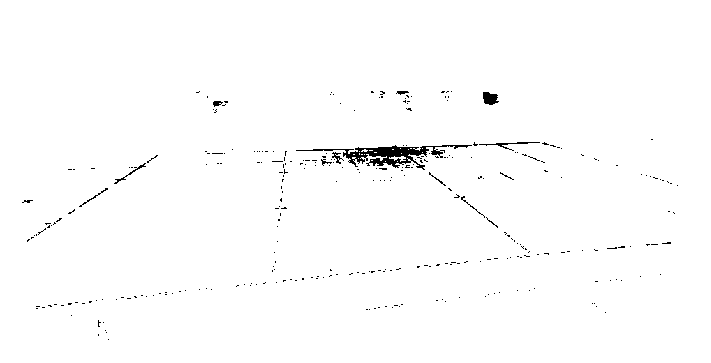

In [48]:
# EXTRACTING WHITE LINES ON GREEN REGION
hsv_field = cv2.inRange(hsv_plane, hsv_lower, hsv_upper)
hsv_field = 255 - hsv_field
plt.figure(figsize=(12.5,40))
plt.imshow(hsv_field,cmap='gray')
plt.axis('off')

(-0.5, 999.5, 499.5, -0.5)

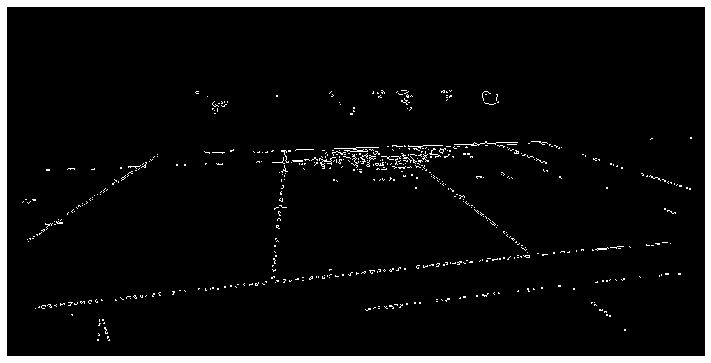

In [49]:
# APPLYING CANNY EDGE DETECTION TO MASK
edges = cv2.Canny(hsv_field,50,50,apertureSize=3)
plt.figure(figsize=(12.5,40))
plt.imshow(edges, cmap='gray')
plt.axis('off')

(-0.5, 999.5, 499.5, -0.5)

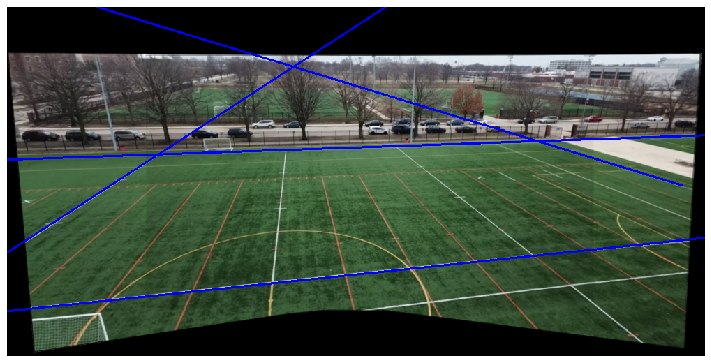

In [50]:
# USING HOUGH LINES TO DETECT LINES
lines = cv2.HoughLines(edges, 0.75, np.pi/180, 65)
thetas = []
corners = []
idx = [0,1,9,48] # choose lines you need
for i in range(4):
    for rho,theta in lines[idx[i]]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(field_lines,(x1,y1),(x2,y2),(0,0,255),2)
        thetas.append(theta)
        corners.append((x1,y1,x2,y2))
        
# BACKGROUND IMAGE WITH FIELD LINES
plt.figure(figsize=(12.5,40))
plt.imshow(field_lines)
plt.axis('off')

### Finding corner coordinates from detected lines

In [51]:
def line_eq(points):
    (x1,y1,x2,y2) = points
    m = (y2-y1)/(x2-x1)
    b = y1-m*x1
    return m, b

In [52]:
def intersection(m, b, u, v):
    x = (b[v]-b[u])/(m[u]-m[v])
    y = m[u]*x+b[u]
    return int(x), int(y)

In [53]:
# CALCULATE SLOPE AND INTERCEPTS OF EACH LINE
slopes = []
intercepts = []
for i in range(4):
    m,b = line_eq(corners[i])
    slopes.append(m)
    intercepts.append(b)

# CALCULATE INTERSECTION OF LINES AS THE 4 CORNERS OF THE FIELD
cx1,cy1 = intersection(slopes,intercepts,0,2)
cx2,cy2 = intersection(slopes,intercepts,1,2)
cx3,cy3 = intersection(slopes,intercepts,1,3)
cx4,cy4 = intersection(slopes,intercepts,0,3)

# CREATE CORNER COORDINATES AS 3xN MATRIX
corner_pts = []
corner_pts.append([cx1,cx2,cx3,cx4])
corner_pts.append([cy1,cy2,cy3,cy4])
corner_pts.append([1,1,1,1])
corner_pts = np.array(corner_pts,dtype=int)

(-0.5, 1399.5, 499.5, -0.5)

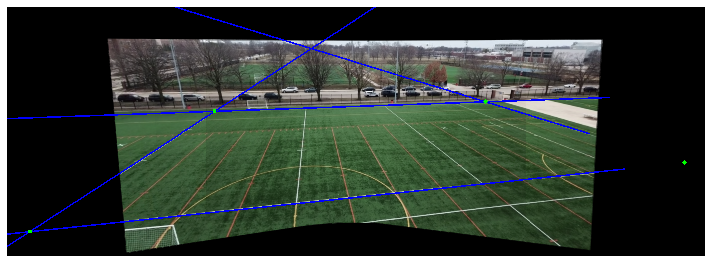

In [54]:
# SET OFFSET VALUE FOR CORNERS OFF THE BACKGROUND IMAGE
off = 200
field_corners = np.zeros((proj_h,proj_w+2*off,3),dtype=np.uint8)
field_corners[:,off:off+proj_w,:] = field.copy()

# OFFSET THE LINES FROM THE ORIGINAL BACKGROUND IMAGE
for i in range(4):
    (x1,y1,x2,y2) = corners[i]
    cv2.line(field_corners,(x1+off,y1),(x2+off,y2),(0,0,255),2)

# PLOT THE CORNER COORDINATES
cv2.circle(field_corners,(cx1+off,cy1),radius=4,color=(0,255,0),thickness=-1)
cv2.circle(field_corners,(cx2+off,cy2),radius=4,color=(0,255,0),thickness=-1)
cv2.circle(field_corners,(cx3+off,cy3),radius=4,color=(0,255,0),thickness=-1)
cv2.circle(field_corners,(cx4+off,cy4),radius=4,color=(0,255,0),thickness=-1)

# BACKGROUND IMAGE WITH FIELD LINES AND CORNERS
plt.figure(figsize=(12.5,40))
plt.imshow(field_corners)
plt.axis('off')

### Detecting players in a single frame

In [55]:
# CREATE MASK FOR FRAME
foreground = 'images/output/clip-{}/foreground/f{:04d}.jpg'.format(clip_num, test_frame)
foreground = cv2.imread(foreground)
hsv = cv2.cvtColor(foreground, cv2.COLOR_BGR2HSV)
mask = cv2.bitwise_and(foreground, foreground, mask=cv2.inRange(hsv, lower, upper))
gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

# FIND CONTOURS FROM MASK, DRAW RECTANGLE, TRACK LOCATIONS
original = 'images/input/clip-{}/f{:04d}.jpg'.format(clip_num, test_frame)
original = cv2.imread(original)
track = original.copy()
player_field = original.copy()
players = []
(_,contours,_) = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
for contour in contours:
    (x,y,w,h) = cv2.boundingRect(contour)
    area = cv2.contourArea(contour)
    if area > a_bd and area/w > aw_bd and ah_lbd < area/h < ah_ubd and area/(w*h) > ar_bd and h/w > r_bd:
        players.append([x+w/2, y+h, 1])
        cv2.rectangle(track, (x,y), (x+w,y+h), (0,0,255), 1)

(-0.5, 639.5, 359.5, -0.5)

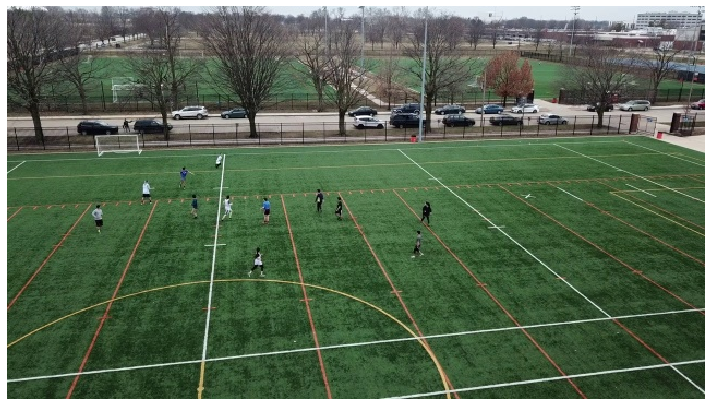

In [56]:
# EXAMPLE FRAME: ORIGINAL FRAME
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12.5,40))
plt.imshow(original)
plt.axis('off')

(-0.5, 639.5, 359.5, -0.5)

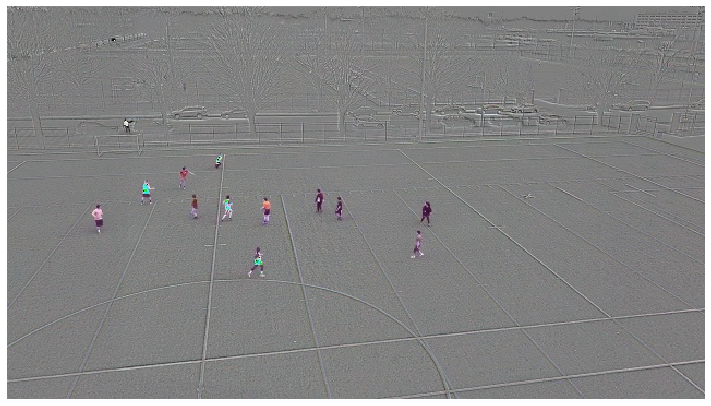

In [57]:
# EXAMPLE FRAME: FOREGROUND FRAME
plt.figure(figsize=(12.5,40))
plt.imshow(foreground)
plt.axis('off')

(-0.5, 639.5, 359.5, -0.5)

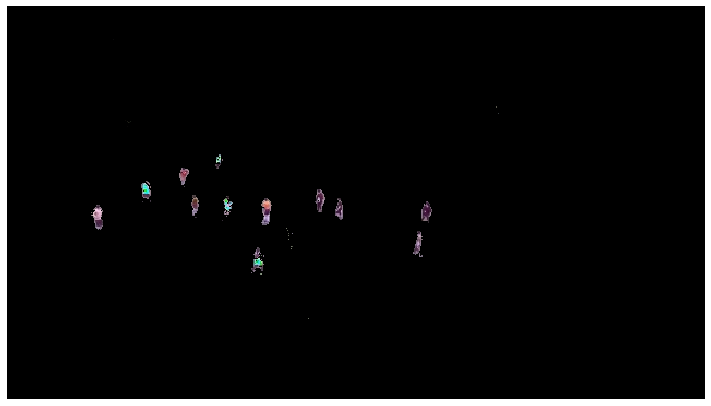

In [58]:
# EXAMPLE FRAME: MASK OF FOREGROUND FRAME
plt.figure(figsize=(12.5,40))
plt.imshow(mask)
plt.axis('off')

(-0.5, 639.5, 359.5, -0.5)

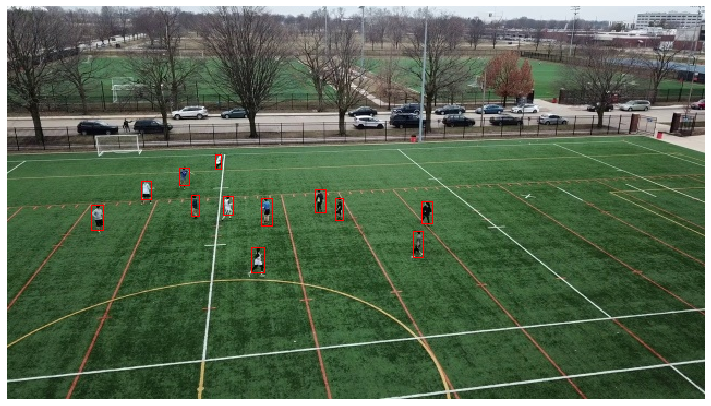

In [59]:
# EXAMPLE FRAME: FRAME OF PLAYER DETECTION
track = cv2.cvtColor(track, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12.5,40))
plt.imshow(track)
plt.axis('off')

### Tracking player locations and mapping onto background image

In [60]:
# GET TRACKED LOCATIONS AND TRANSPOSE INTO 3xN MATRIX FOR MAPPING
players = np.array(players,dtype=int).T

# APPLY HOMOGRAPHIES TO MATRIX TO GET PLAYER COORDINATES ON THE BACKGROUND IMAGE
if test_frame != 5*invl:
    mapped_players = homographies[test_frame-1]@players
    for i in range(len(mapped_players[0])):
        mapped_players[:,i] /= mapped_players[2,i]
else:
    mapped_players = np.ones((3,len(players[0])))
    mapped_players[0:2] = np.array([[1,0,-1*tx],[0,1,-1*ty]])@players
mapped_players = mapped_players.astype(int)
mapped_players[0] = [x+off for x in mapped_players[0]]

# PLOT PLAYER LOCATIONS ONTO FRAME
for i in range(len(players[0])):
    x = players[0,i]
    y = players[1,i]
    cv2.circle(player_field,(x,y),radius=2,color=(0,0,255),thickness=-1)
    
# APPLY INVERSE HOMOGRAPHIES TO MATRIX TO GET CORNERS COORDINATES ON A FRAME
if test_frame != 5*invl:
    Hi_i = inv(np.matrix(homographies[test_frame-1]))
    mapped_corners = Hi_i@corner_pts
    for j in range(4):
        mapped_corners[:,j] /= mapped_corners[2,j]
else:
    mapped_corners = np.ones((3,4))
    mapped_corners[0:2] = np.array([[1,0,tx],[0,1,ty]])@corner_pts
mapped_corners = mapped_corners.astype(int)

(-0.5, 639.5, 359.5, -0.5)

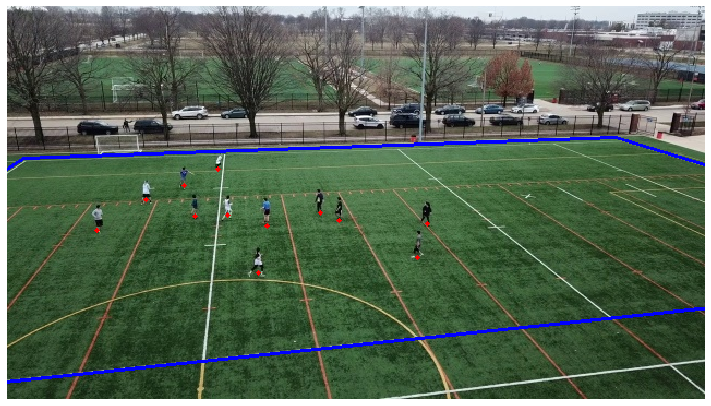

In [61]:
# GET MAPPED CORNER COORDINATES AND DRAW LINES ONTO FRAME
x1,y1 = mapped_corners[0,0], mapped_corners[1,0]
x2,y2 = mapped_corners[0,1], mapped_corners[1,1]
x3,y3 = mapped_corners[0,2], mapped_corners[1,2]
x4,y4 = mapped_corners[0,3], mapped_corners[1,3]
cv2.line(player_field,(x1,y1),(x2,y2),(255,0,0),2)
cv2.line(player_field,(x2,y2),(x3,y3),(255,0,0),2)
cv2.line(player_field,(x3,y3),(x4,y4),(255,0,0),2)
cv2.line(player_field,(x4,y4),(x1,y1),(255,0,0),2)

# EXAMPLE FRAME: PLAYER LOCATIONS AND FIELD LINES
player_field = cv2.cvtColor(player_field, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12.5,40))
plt.imshow(player_field)
plt.axis('off')

(-0.5, 1399.5, 499.5, -0.5)

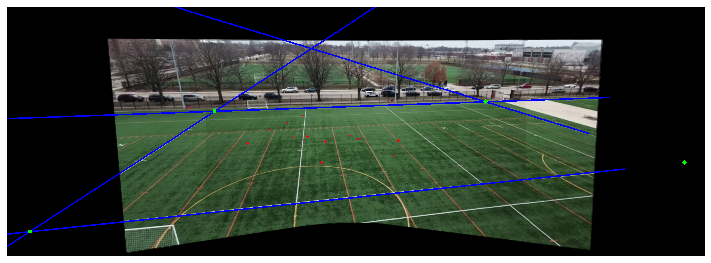

In [62]:
# PLOT MAPPED PLAYER LOCATIONS ONTO BACKGROUND IMAGE
full_field = field_corners.copy()
for i in range(len(mapped_players[0])):
    x = mapped_players[0,i]
    y = mapped_players[1,i]
    cv2.circle(full_field,(x,y),radius=2,color=(255,0,0),thickness=-1)
    
# EXAMPLE FRAME: FULL FIELD WITH PLAYERS AND LINES
plt.figure(figsize=(12.5,40))
plt.imshow(full_field)
plt.axis('off')

### Warping to bird's-eye view and mapping players locations into minimap

(-0.5, 127.5, 71.5, -0.5)

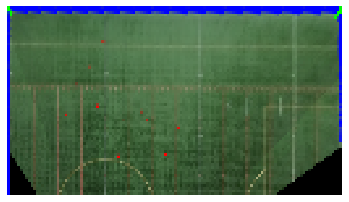

In [63]:
# GET TRANSFORMATION MATRIX AND WARP FIELD FOR BIRD'S-EYE VIEW
src = np.array([[cx1+off,cy1],[cx2+off,cy2],[cx3+off,cy3],[cx4+off,cy4]], np.float32)
dst = np.array([[0,0],[0,map_h],[map_w,map_h],[map_w,0]], np.float32)
M = cv2.getPerspectiveTransform(src,dst)
warped = cv2.warpPerspective(full_field,M,(map_w,map_h))

# EXAMPLE: BIRD'S-EYE VIEW
plt.figure()
plt.imshow(warped)
plt.axis('off')

In [64]:
# APPLY TRANSFORMATION MATRIX TO GET PLAYER COORDINATES ON MINIMAP
minimap_player = M@mapped_players
for i in range(len(minimap_player[0])):
    minimap_player[:,i] /= minimap_player[2,i]
minimap_player = minimap_player.astype(int)

# PLOT LINES ONTO MINIMAP
minimap = np.zeros((map_h,map_w,3), np.uint8)
minimap[:,:,0:3] = [146,208,80]
minimap[0,:,:] = [0,0,255]
minimap[:,0,:] = [0,0,255]
minimap[map_h-1,:,:] = [0,0,255]
minimap[:,map_w-1,:] = [0,0,255]

# PLOT PLAYER ONTO MINIMAP
for i in range(len(minimap_player[0])):
    x = minimap_player[0,i]
    y = minimap_player[1,i]
    if 0 < x < map_w and 0 < y < map_h:
        cv2.circle(minimap,(x,y),radius=1,color=(255,0,0),thickness=-1)

(-0.5, 127.5, 71.5, -0.5)

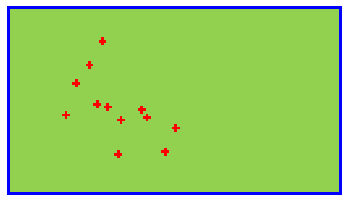

In [65]:
# EXAMPLE: MINIMAP FOR SINGLE FRAME
plt.figure()
plt.imshow(minimap)
plt.axis('off')

### Generate minimap of field for video clip

In [66]:
# READ THE FOREGROUND MOVIE AS THE PRE-PROCESSED DATA
dir_frames = 'images/output/clip-{}/foreground/'.format(clip_num)
filenames = []

filesinfo = os.scandir(dir_frames)
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels), dtype=np.uint8)

for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.imread(file_i)

In [67]:
# INITIALIZE IMPORTANT VARIABLES
n = len(frames)
mask = np.zeros((n,res_h,res_w,3), dtype=np.uint8)
track = np.zeros((n,res_h,res_w,3), dtype=np.uint8)
minimap = np.zeros((n,map_h,map_w,3), dtype=np.uint8)
final = np.zeros((n,res_h,res_w,3), dtype=np.uint8)

# APPLY THE ABOVE STEPS TO ALL FRAMES
for i in range(n):
    # CREATE MASK
    hsv = cv2.cvtColor(frames[i], cv2.COLOR_BGR2HSV)
    mask[i] = cv2.bitwise_and(frames[i], frames[i], mask=cv2.inRange(hsv, lower, upper))
    gray = cv2.cvtColor(mask[i], cv2.COLOR_BGR2GRAY)
        
    # FIND CONTOURS FROM MASK, DRAW RECTANGLE, TRACK LOCATIONS
    original = 'images/input/clip-{}/f{:04d}.jpg'.format(clip_num, i+1)
    track[i] = cv2.imread(original)
    players = []
    colors = []
    (_,contours,_) = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for contour in contours:
        (x,y,w,h) = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if area > 19 and area/w > 3 and 1 < area/h < 8 and area/(w*h) > 0.2 and h/w > 0.5:
            cv2.rectangle(track[i], (x,y), (x+w,y+h), (0,0,255), 1)
            players.append([x+w/2, y+h, 1])
    players = np.array(players,dtype=int).T

    # APPLY HOMOGRAPHIES TO MATRIX TO GET PLAYER COORDINATES ON THE BACKGROUND IMAGE
    if i+1 != 5*invl:
        mapped_players = homographies[i]@players
        for j in range(len(mapped_players[0])):
            mapped_players[:,j] /= mapped_players[2,j]
    else:
        mapped_players = np.ones((3,len(players[0])))
        mapped_players[0:2] = np.array([[1,0,-1*tx],[0,1,-1*ty]])@players
    mapped_players = mapped_players.astype(int)
    mapped_players[0] = [x+off for x in mapped_players[0]]
    
    # SAVE FRAMES OF TRACKED PLAYERS
    # cv2.imwrite('images/output/clip-{}/track/t{:04d}.jpg'.format(clip_num, i+1), track[i])
    final[i] = track[i].copy()
    
    # APPLY INVERSE HOMOGRAPHIES TO MATRIX TO GET CORNERS COORDINATES
    if i+1 != 5*invl:
        Hi_i = inv(np.matrix(homographies[i]))
        mapped_corners = Hi_i@corner_pts
        for j in range(4):
            mapped_corners[:,j] /= mapped_corners[2,j]
    else:
        mapped_corners = np.ones((3,4))
        mapped_corners[0:2] = np.array([[1,0,tx],[0,1,ty]])@corner_pts
    mapped_corners = mapped_corners.astype(int)
    
    # GET MAPPED CORNER COORDINATES AND DRAW LINES
    x1,y1 = mapped_corners[0,0], mapped_corners[1,0]
    x2,y2 = mapped_corners[0,1], mapped_corners[1,1]
    x3,y3 = mapped_corners[0,2], mapped_corners[1,2]
    x4,y4 = mapped_corners[0,3], mapped_corners[1,3]
    cv2.line(final[i],(x1,y1),(x2,y2),(255,0,0),2)
    cv2.line(final[i],(x2,y2),(x3,y3),(255,0,0),2)
    cv2.line(final[i],(x3,y3),(x4,y4),(255,0,0),2)
    cv2.line(final[i],(x4,y4),(x1,y1),(255,0,0),2)
        
    # APPLY TRANSFORMATION MATRIX TO GET PLAYER COORDINATES ON MINIMAP
    minimap_player = M@mapped_players
    for j in range(len(minimap_player[0])):
        minimap_player[:,j] /= minimap_player[2,j]
    minimap_player = minimap_player.astype(int)
    
    # GENERATE MINIMAP FOR EACH FRAME
    minimap[i,:,:,0:3] = [80,208,146]
    minimap[i,0:2,:,:] = [255,0,0]
    minimap[i,:,0:2,:] = [255,0,0]
    minimap[i,map_h-2:map_h,:,:] = [255,0,0]
    minimap[i,:,map_w-2:map_w,:] = [255,0,0]
    for j in range(len(minimap_player[0])):
        x = minimap_player[0,j]
        y = minimap_player[1,j]
        if 5 < x < map_w-5 and 5 < y < map_h-5:
            cv2.circle(minimap[i],(x,y),radius=2 ,color=(0,0,255),thickness=-1)
            
    # PLACE MINIMAP ON BOTTOM CORNER OF FRAMES WITH PLAYER DETECTION AND SAVE FRAMES
    final[i,res_h-map_h-5:res_h-5,res_w-map_w-5:res_w-5,:] = minimap[i]
    cv2.imwrite('images/output/clip-{}/minimap/m{:04d}.jpg'.format(clip_num, i+1), final[i])

In [68]:
# OPTION 1: GENERATE VIDEO WITH PLAYER DETECTION AND MINIMAP TRACKING
utils.imageFolder2mpeg('images/output/clip-{}/minimap'.format(clip_num), fps=30)

# OPTION 2: GENERATE SAME VIDEO AS ABOVE AS MP4
# utils.imageFolder2mpeg('images/output/clip-{}/minimap'.format(clip_num), fps=30)